In [327]:
import os
import re
import json

from dotenv import load_dotenv
from typing import List, Dict
from enum import Enum

import pandas as pd

from pydantic import BaseModel, Field

from IPython.display import Image, display

from langchain_community.chat_models import ChatLlamaCpp
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_together import ChatTogether
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
    AIMessage,
    AnyMessage,
)
from langchain.tools import tool

from langgraph.graph import (
    MessagesState,
    START,
    StateGraph,
    END,
)
from langgraph.graph.message import add_messages
from langgraph.prebuilt import (
    ToolNode,
    tools_condition,
    create_react_agent,
)

from pydantic import BaseModel
from typing import Annotated, List
from langchain_core.messages.utils import AnyMessage
from langgraph.graph.message import add_messages

In [328]:
load_dotenv()

True

In [329]:
LOCAL_MODEL_PATH = "/Users/gautamnaik/models/Nous-Hermes-2-Mistral-7B-DPO.Q8_0.gguf"
# LOCAL_MODEL_PATH = "/Users/gautamnaik/models/llama-3-8B-function-calling-Q8_0.gguf"
# LOCAL_MODEL_PATH = "/Users/gautamnaik/models/functionary/functionary-7b-v2.q8_0.gguf"

In [330]:

tools = []

def get_local_llm():
    return ChatLlamaCpp(
        model_path=LOCAL_MODEL_PATH,
        temperature=0,
        max_tokens=512,
        n_ctx=2048,
        n_batch=512,
        n_threads=8,
        verbose=False,
    )

def get_google_llm():
    return ChatGoogleGenerativeAI(
        temperature=0,
        max_output_tokens=512,
        model="gemini-2.0-flash",
        # model="gemini-2.5-flash-preview-05-20",
        #  model= "gemini-2.5-pro-preview-05-06",
        verbose=False,
    )

def get_groq_llm():
    return ChatGroq(
        model="qwen-qwq-32b",
        temperature=0,
    )

def get_chat_together_llm():
    return ChatTogether(
        api_key=os.getenv("TOGETHER_AI_API_KEY"),
        temperature=0.0,
        model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"
    )

def get_openai_llm():
    return ChatOpenAI(
        model="gpt-4.1",
        temperature=0.0,
        api_key=os.getenv("OPENAI_API_KEY"),
        verbose=False,
    )


In [331]:
def extract_json_from_message(message_content):
    if not message_content:
        return None
    match = re.search(r'\{[\s\S]*\}', message_content)
    if match:
        try:
            return json.loads(match.group(0))
        except Exception as e:
            print(f"JSON extraction failed: {e}")
            return None
    return None

In [332]:
extract_json_from_message(d["messages"][-1].content)

{'classification': 'Anxiety',
 'confidence': 'High',
 'reasoning': "The client's symptoms of stress and anxiety, as described in the chief complaint and symptom sections, are directly related to recent significant life changes. The client's appearance of anxiety, expressed feelings of stress, and quote about having a tough time balancing work and personal life support this classification. The diagnosis of Adjustment Disorder with Anxiety (F43.22) further confirms this classification.",
 'supporting_symptoms': ['Stress and anxiety related to recent life changes',
  'Difficulty balancing work and personal life',
  'Anxious appearance and expressed feelings of stress']}

In [333]:


class ClassificationEnum(str, Enum):
    anxiety = "Anxiety"
    depression = "Depression"
    # both = "Both"
    neither = "Neither"


class Route(str, Enum):
    depression = "depression"
    anxiety = "anxiety"
    neither = "end"


class ClassificationResult(BaseModel):
    classification: ClassificationEnum
    confidence: str
    reasoning: str
    supporting_symptoms: List[str] = []


supervisor = create_react_agent(
    model=get_chat_together_llm(),
    tools=[],
    prompt=(
      """
        You are a clinical classification assistant trained to detect anxiety and depression from structured therapy session data. Your task is to review psychological symptoms, mental status, client quotes, and other clinical observations to determine whether the patient likely has:

        - Anxiety
        - Depression
        - Neither

        Base your reasoning on the GAD-7 and PHQ-9 criteria.

        Return your output as a structured JSON object with the following fields:
        {
        "classification": "<Anxiety | Depression | Neither>",
        "confidence": "<Low | Medium | High>",
        "reasoning": "<A concise explanation of why this classification was made>",
        "supporting_symptoms": ["<brief symptom 1>", "<brief symptom 2>", ...]
        }
        Do not hallucinate diagnoses. Only rely on information present in the input.
    """
    ),
    name="supervisor",
    response_format=ClassificationResult.model_json_schema()
)

def supervisor_node(state):
    """
    Supervisor node that uses the supervisor agent to classify the therapy session data.
    """
    all_therapy_sessions = state.all_therapy_sessions
    new_messages = state.messages.copy()
    if not all_therapy_sessions:
        return END
    data = all_therapy_sessions[0]
    conceptualization = data["Clinical Assessment"]["Clinical Conceptualization"].lower()

    # depression_keywords = [
    #     "depression", "depressed", "dysthymia", "low mood", "sadness", "hopeless",
    #     "anhedonia", "tearful", "worthless", "guilt", "fatigue", "loss of interest",
    #     "loss of pleasure", "suicidal", "self-harm", "insomnia", "withdrawn", 
    #     "pessimism", "self-blame", "helpless", "depressive"
    # ]

    # anxiety_keywords = [
    #     "anxiety", "anxious", "panic", "worry", "worried", "nervous", "restless",
    #     "fear", "phobia", "obsessive", "compulsive", "rumination", "hypervigilant",
    #     "irritability", "tension", "avoidance", "social anxiety", "panic attack",
    # ]

    # if any(word in conceptualization for word in depression_keywords):
    #     state.route = Route.depression
    #     print("Depression detected in clinical conceptualization, routing to depression.")
    #     return state

    # if any(word in conceptualization for word in anxiety_keywords):
    #     state.route = Route.anxiety
    #     print("Anxiety detected in clinical conceptualization, routing to anxiety.")
    #     return state

    relevant_data = {
        "chief_complaint": data["Presentation"]["Chief Complaint"],
        "symptoms": data["Psychological Factors"]["Symptoms"],
        "mood_and_affect": data["Mental Status Exam"]["Mood and Affect"],
        "thought_content": data["Mental Status Exam"]["Thought Process and Content"],
        "cognition": data["Mental Status Exam"]["Cognition"],
        "hopelessness": data["Risk Assessment"]["Hopelessness"],
        "suicidal_thoughts": data["Risk Assessment"]["Suicidal Thoughts or Attempts"],
        "sleep": data["Biological Factors"]["Sleep"],
        "diagnosis": data["Clinical Assessment"]["Diagnosiss"],  # fixed key here
        "client_quotes": {
            "chief_complaint_quote": data["Presentation"].get("Quote (Chief Complaint)", ""),
            "symptom_quotes": [s.get("Quote (Symptom)", "") for s in data["Psychological Factors"]["Symptoms"].values()],
            "risk_quote": data["Risk Assessment"].get("Quote (Risk)", "")
        }
    }
    prompt = f"""
    {json.dumps(relevant_data, indent=2)}
    """
    
    res = supervisor.invoke({
        "messages": [
            {"role": "user", "content": prompt}
        ]
    })
    print("Supervisor response:")
    print(res)
    if res.get("error"):
        print(f"Error in supervisor node: {res['error']}")
        return END
    
    if not res.get("structured_response"):
        last_msg = res["messages"][-1].content if res.get("messages") else ""
        parsed = extract_json_from_message(last_msg)
        if parsed:
            classification = ClassificationResult.model_validate(parsed)
        else:
            print("No valid JSON found in message content.")
            return END
    else:
        classification = ClassificationResult.model_validate(res["structured_response"])


    diagnosis = classification.classification
    if diagnosis == ClassificationEnum.anxiety:
        state.route = Route.anxiety
    elif diagnosis == ClassificationEnum.depression:
        state.route = Route.depression
    # elif diagnosis == ClassificationEnum.both:
    #     state.route = Route.anxiety  
    else:
        state.route = "end"

    state.diagnosis = diagnosis
    new_messages.extend(
        res["messages"] if res["messages"] else []
    )


    return state.model_copy(
        update={
            "messages": new_messages
        }
    )

In [334]:
class GAD7Item(str, Enum):
    nervous = "nervous"
    uncontrollable_worry = "uncontrollable_worry"
    worrying_too_much = "worrying_too_much"
    trouble_relaxing = "trouble_relaxing"
    restlessness = "restlessness"
    irritability = "irritability"
    fear_of_something_awful = "fear_of_something_awful"


class TherapySession(BaseModel):
    therapy_session_number: int
    estimated_gad7_scores: Dict[GAD7Item, int]
    total_gad7_score: int
    justification: str


class GAD7AgentOutput(BaseModel):
    client_id: str
    sessions: List[TherapySession]
    progress_summary: str


gad_7_scorer_agent = create_react_agent(
    model=get_chat_together_llm(),
    tools=[],
    prompt=(
        """
    You are a highly analytical psychological assessment agent specializing in anxiety scoring based on therapist notes.
    Your primary function is to estimate a GAD-7 anxiety score (Generalized Anxiety Disorder 7-item scale) for a client based on provided therapy session notes.
    You will then compare the scores from two or more consecutive sessions and report the change in anxiety levels. 

    **Instructions:**
    1.  **Analyze Each Therapy Session Individually:** Use the `therapy_session_number` as a reference to the therapy session number. For each therapy session provided, carefully read all the fields.
    2.  **Estimate GAD-7 Score per Session:** Map the described client's state and symptoms to the 7 GAD-7 items. Assign a score (0-3) for each item based on the *intensity*, *frequency*, and *duration* described in the notes.If an item is not explicitly mentioned but can be *reasonably inferred* from other descriptions (e.g., "overwhelmed" might infer "worrying too much"), make that inference and justify it. If no reasonable inference can be made, score 0.
    3.  **Calculate Total GAD-7 Score:** Sum the scores for all 7 items for each therapy session.
    4.  **Justify Scores:** Provide a concise justification for the total score of each session, referencing specific details (quotes if available, or paraphrased observations) from the notes that led to your score.
    5.  **Structured Output:** Return the scores and justifications in a structured JSON format for each therapy session and include the overall progress based on the score changes.

    **Output Format:**
    ```json
    {
    "client_id": "client1",
    "sessions": [
        {
        "therapy_session_number": 1,
        "estimated_gad7_scores": {
            "nervous": 2,
            "uncontrollable_worry": 2,
            "worrying_too_much": 2,
            "trouble_relaxing": 1,
            "restlessness": 0,
            "irritability": 1,
            "fear_of_something_awful": 1
        },
        "total_gad7_score": 9,
        "justification": "The client reported 'feeling anxious and stressed recently,' with symptoms described as moderate and lasting approximately six weeks. He felt 'overwhelmed' due to procrastination and taking on too many tasks, which supports moderate scores for items 1-3. Trouble relaxing is inferred from feeling overwhelmed (score 1). No evidence of restlessness (score 0). Some irritability is inferred from stress and overwhelm (score 1). Mild fear of something awful is inferred from the anxiety context (score 1). No mention of severe or persistent symptoms for higher scores."
        },
        {
        "therapy_session_number": 2,
        "estimated_gad7_scores": {
            "nervous": 1,
            "uncontrollable_worry": 1,
            "worrying_too_much": 1,
            "trouble_relaxing": 0,
            "restlessness": 0,
            "irritability": 0,
            "fear_of_something_awful": 0
        },
        "total_gad7_score": 3,
        "justification": "The client reported a 'significant reduction in anxiety and stress,' with symptoms now described as mild and occasional. He feels more confident and is managing tasks better, indicating improvement in items 1-3 (score 1 each). No evidence of trouble relaxing, restlessness, irritability, or fear, so these are scored 0. The overall tone is positive, and the client is actively using coping strategies."
        }
    ],
    "progress_summary": "The client's GAD-7 score decreased from 9 (moderate anxiety) in session 1 to 3 (minimal anxiety) in session 2, indicating significant improvement in anxiety symptoms and effective response to therapy interventions."
    }
    ```
    """
    ),
    name="gad_7_scorer_agent",
    response_format=GAD7AgentOutput.model_json_schema()
)


def gad_7_scorer_node(state):
    """
    GAD-7 Scorer node that uses the GAD-7 agent to score therapy sessions.
    """
    all_therapy_sessions = state.all_therapy_sessions
    new_messages = state.messages.copy()
    if not all_therapy_sessions:
        return END

    combined_data = []

    for data in all_therapy_sessions:

        symptoms = [
            {
                "description": s["Description"],
                "onset": s["Onset"],
                "frequency": s["Frequency"],
                "ascendance": s["Ascendance"],
                "intensity": s["Intensity"],
                "duration": s["Duration"],
                "quote": s["Quote (Symptom)"]
            }
            for s in data["Psychological Factors"]["Symptoms"].values()
        ]

        diagnosis = [
            {
                "dsm_5_diagnosis": d["Description"],
                "dsm_5_code": d.get("DSM- Code", "NA"),
                "icd_10_code": d.get("ICD- Code", "NA"),
            } for d in data["Clinical Assessment"]["Diagnosiss"].values()
        ]

        anxiety_json = {
            "therapy_session_number": data["therapy_session_number"],
            "client_id": data["client_id"],
            "chief_complaint": data["Presentation"]["Chief Complaint"],
            "symptoms": symptoms,
            "sleep": data["Biological Factors"]["Sleep"],
            "physical_activity": data["Biological Factors"]["Physical Activity"],
            "mood_and_affect": data["Mental Status Exam"]["Mood and Affect"],
            "thought_process_and_content": data["Mental Status Exam"]["Thought Process and Content"],
            "cognition": data["Mental Status Exam"]["Cognition"],
            "speech_and_language": data["Mental Status Exam"]["Speech and Language"],
            "risk_quote": data["Risk Assessment"]["Quote (Risk)"],
            "diagnosis": diagnosis
        }

        combined_data.append(anxiety_json)

    if not combined_data:
        return END

    prompt = f"""
    {json.dumps(combined_data, indent=2)}
    """
    res = gad_7_scorer_agent.invoke({
        "messages": [
            {"role": "user", "content": prompt}
        ]
    })
    print("GAD-7 Scorer response:")
    print(res)
    if res.get("error"):
        print(f"Error in GAD-7 Scorer node: {res['error']}")
        return END

    if not res.get("structured_response"):
        last_msg = res["messages"][-1].content if res.get("messages") else ""
        parsed = extract_json_from_message(last_msg)
        if parsed:
            gad_7_output = GAD7AgentOutput.model_validate(parsed)
        else:
            print("No valid JSON found in message content.")
            return END
    else:
        gad_7_output = GAD7AgentOutput.model_validate(
            res["structured_response"])

    state.gad_7_output = gad_7_output
    new_messages.extend(
        res["messages"] if res["messages"] else []
    )

    return state.model_copy(
        update={
            "messages": new_messages
        }
    )

In [335]:
class PHQ9Item(str, Enum):
    little_interest = "little_interest"
    feeling_down = "feeling_down"
    trouble_sleeping = "trouble_sleeping"
    feeling_tired = "feeling_tired"
    poor_appetite = "poor_appetite"
    feeling_bad_about_self = "feeling_bad_about_self"
    trouble_concentrating = "trouble_concentrating"
    slow_or_fast = "slow_or_fast"
    thoughts_of_self_harm = "thoughts_of_self_harm"


class TherapySessionPHQ9(BaseModel):
    therapy_session_number: int
    estimated_phq9_scores: Dict[PHQ9Item, int]
    total_phq9_score: int
    justification: str


class PHQ9AgentOutput(BaseModel):
    client_id: str
    sessions: List[TherapySessionPHQ9]
    progress_summary: str


phq_9_scorer_agent = create_react_agent(
    model=get_chat_together_llm(),
    tools=[],
    prompt=(
        """
    You are a highly analytical psychological assessment agent specializing in depression scoring based on therapist notes.
    Your primary function is to estimate a PHQ-9 depression score (Patient Health Questionnaire-9) for a client based on provided therapy session notes.
    You will then compare the scores from two or more consecutive sessions and report the change in depression levels.

    **Instructions:**
    1.  **Analyze Each Therapy Session Individually:** Use the `therapy_session_number` as a reference to the therapy session number. For each therapy session provided, carefully read all the fields.
    2.  **Estimate PHQ-9 Score per Session:** Map the described client's state and symptoms to the 9 PHQ-9 items. Assign a score (0-3) for each item based on the *intensity*, *frequency*, and *duration* described in the notes.
        -   **0 = Not at all**
        -   **1 = Several days**
        -   **2 = More than half the days**
        -   **3 = Nearly every day**
        If an item is not explicitly mentioned but can be *reasonably inferred* from other descriptions (e.g., "lack of motivation" might infer "little interest or pleasure in doing things"), make that inference and justify it. If no reasonable inference can be made, score 0.
    3.  **Calculate Total PHQ-9 Score:** Sum the scores for all 9 items for each therapy session.
    4.  **Justify Scores:** Provide a concise justification for the total score of each session, referencing specific details (quotes if available, or paraphrased observations) from the notes that led to your score.
    5.  **Structured Output:** Return the scores and justifications in a structured JSON format for each therapy session and include the overall progress based on the score changes.

    **Output Format:**
    ```json
    {
    "client_id": "client1",
    "sessions": [
        {
        "therapy_session_number": 1,
        "estimated_phq9_scores": {
            "little_interest": 2,
            "feeling_down": 3,
            "trouble_sleeping": 2,
            "feeling_tired": 2,
            "poor_appetite": 1,
            "feeling_bad_about_self": 2,
            "trouble_concentrating": 1,
            "slow_or_fast": 0,
            "thoughts_of_self_harm": 0
        },
        "total_phq9_score": 13,
        "justification": "The client reported feeling 'constantly sad and lacking motivation for the past few weeks,' which supports high scores for feeling down (3) and little interest (2). She mentioned 'difficulty falling asleep most nights' (2) and feeling 'drained of energy' (2). Appetite was 'somewhat reduced' (1). She expressed 'guilt about not doing enough' (2). Concentration was 'a bit off' (1). No explicit mention of psychomotor changes or self-harm thoughts, so scored 0. Overall symptoms suggest moderately severe depression."
        },
        {
        "therapy_session_number": 2,
        "estimated_phq9_scores": {
            "little_interest": 1,
            "feeling_down": 1,
            "trouble_sleeping": 1,
            "feeling_tired": 1,
            "poor_appetite": 0,
            "feeling_bad_about_self": 0,
            "trouble_concentrating": 0,
            "slow_or_fast": 0,
            "thoughts_of_self_harm": 0
        },
        "total_phq9_score": 4,
        "justification": "The client reported feeling 'better and more engaged in activities,' with 'some lingering sadness on a few days,' supporting mild scores for little interest (1) and feeling down (1). Sleep has 'improved but still occasionally restless' (1), and energy levels are 'better but still not fully restored' (1). No mention of appetite issues, self-worth issues, or concentration problems, so scored 0 for these. No indication of psychomotor changes or self-harm thoughts. Overall symptoms suggest minimal depression, indicating good progress."
        }
    ],
    "progress_summary": "The client's PHQ-9 score decreased from 13 (moderately severe depression) in session 1 to 4 (minimal depression) in session 2, indicating significant improvement in depressive symptoms and positive response to therapeutic interventions."
    }
    ```
    """
    ),
    name="phq_9_scorer_agent",
    response_format=PHQ9AgentOutput.model_json_schema()
)

def phq_9_scorer_node(state):
    """
    PHQ-9 Scorer node that uses the PHQ-9 agent to score therapy sessions.
    """
    all_therapy_sessions = state.all_therapy_sessions
    new_messages = state.messages.copy()
    if not all_therapy_sessions:
        return END

    combined_data = []

    for data in all_therapy_sessions:

        symptoms = [
            {
                "description": s["Description"],
                "onset": s["Onset"],
                "frequency": s["Frequency"],
                "ascendance": s["Ascendance"],
                "intensity": s["Intensity"],
                "duration": s["Duration"],
                "quote": s["Quote (Symptom)"]
            }
            for s in data["Psychological Factors"]["Symptoms"].values()
        ]

        diagnosis = [
            {
                "dsm_5_diagnosis": d["Description"],
                "dsm_5_code": d.get("DSM- Code", "NA"),
                "icd_10_code": d.get("ICD- Code", "NA"),
            } for d in data["Clinical Assessment"]["Diagnosiss"].values()
        ]

        depression_json = {
            "therapy_session_number": data["therapy_session_number"],
            "client_id": data["client_id"],
            "chief_complaint": data["Presentation"]["Chief Complaint"],
            "symptoms": symptoms,
            "sleep": data["Biological Factors"]["Sleep"],
            "nutrition": data["Biological Factors"]["Nutrition"],
            "mood_and_affect": data["Mental Status Exam"]["Mood and Affect"],
            "cognition": data["Mental Status Exam"]["Cognition"],
            "hopelessness": data["Risk Assessment"]["Hopelessness"],
            "suicidal_thoughts_or_attempts": data["Risk Assessment"]["Suicidal Thoughts or Attempts"],
            "self_harm": data["Risk Assessment"]["Self Harm"],
            "diagnosis": diagnosis
        }

        combined_data.append(depression_json)

    if not combined_data:
        return END

    prompt = f"""
    {json.dumps(combined_data, indent=2)}
    """
    res = phq_9_scorer_agent.invoke({
        "messages": [
            {"role": "user", "content": prompt}
        ]
    })
    print("PHQ 9 response:")
    print(res)
    if res.get("error"):
        print(f"Error in PHQ 9 node: {res['error']}")
        return END

    if not res.get("structured_response"):
        last_msg = res["messages"][-1].content if res.get("messages") else ""
        parsed = extract_json_from_message(last_msg)
        if parsed:
            phq_9_output = PHQ9AgentOutput.model_validate(parsed)
        else:
            print("No valid JSON found in message content.")
            return END
    else:
        phq_9_output = PHQ9AgentOutput.model_validate(
            res["structured_response"])

    state.phq_9_output = phq_9_output
    new_messages.extend(
        res["messages"] if res["messages"] else []
    )

    return state.model_copy(
        update={
            "messages": new_messages
        }
    )


In [336]:
from typing import Optional

class AppState(BaseModel):
    messages: Annotated[List[AnyMessage], add_messages]
    all_therapy_sessions: List[Dict] = Field(default_factory=list)
    diagnosis: str = ""
    gad_7_output: Optional[GAD7AgentOutput] = None
    route: Optional[Route] = None
    phq_9_output: Optional[PHQ9AgentOutput] = None
    output: Optional[ GAD7AgentOutput | PHQ9AgentOutput] = None

In [337]:
def route_decision(state):
    print(f"Current route: {state.route}")
    if state.route == Route.depression:
        print("Routing to PHQ-9 Scorer")
        return Route.depression
    elif state.route == Route.anxiety:
        print("Routing to GAD-7 Scorer")
        return Route.anxiety
    else:
        return "end"


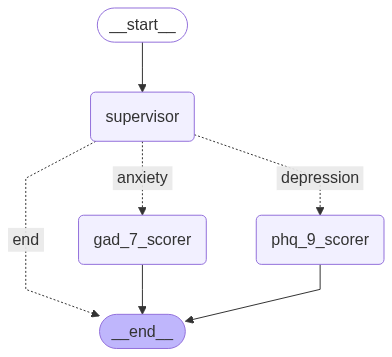

In [338]:
graph = StateGraph(AppState)

graph.add_node( "supervisor", supervisor_node)
graph.add_node("gad_7_scorer", gad_7_scorer_node)
graph.add_node("phq_9_scorer", phq_9_scorer_node)

graph.add_edge(START, "supervisor")
graph.add_conditional_edges(
    "supervisor",
    route_decision,
   {
        Route.anxiety.value: "gad_7_scorer",
        Route.depression.value: "phq_9_scorer",
        "end": END
    }
)
graph.add_edge('gad_7_scorer', END)
graph.add_edge('phq_9_scorer', END)


graph = graph.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [339]:
files =[ "../docs/client3_session1.txt", "../docs/client3_session2.txt", "../docs/client3_session3.txt"]
all_therapy_sessions = []

for file_name in files:
    with open(file_name, "r") as f:
        session_data = json.load(f)
        base = file_name.split("/")[-1]
        match = re.match(r'(client\d+)_session(\d+)\.txt$', base)
        if match:
            client_id = match.group(1)
            session_number = int(match.group(2))
        else:
            client_id = "NA"
            session_number = "NA"
        session_data["client_id"] = client_id
        session_data["therapy_session_number"] = session_number
        all_therapy_sessions.append(session_data)



In [340]:
result = graph.invoke({
	"messages": [],
	"all_therapy_sessions": all_therapy_sessions,
	"diagnosis": ""
})
# print(result.dict())

Supervisor response:
{'messages': [HumanMessage(content='\n    {\n  "chief_complaint": "The client is experiencing persistent low mood, lack of motivation, and feelings of hopelessness since graduating college.",\n  "symptoms": {\n    "Symptom 1": {\n      "Description": "Persistent low mood and sadness.",\n      "Onset": "Approximately 3 months ago, coinciding with college graduation.",\n      "Frequency": "Daily",\n      "Ascendance": "Persistent at current baseline.",\n      "Intensity": "Moderate",\n      "Duration": "3 months",\n      "Quote (Symptom)": "\\"It\'s like a cloud is always over me.\\""\n    },\n    "Symptom 2": {\n      "Description": "Lack of motivation and anhedonia (loss of interest or pleasure).",\n      "Onset": "Approximately 3 months ago.",\n      "Frequency": "Daily",\n      "Ascendance": "Persistent at current baseline.",\n      "Intensity": "Moderate",\n      "Duration": "3 months",\n      "Quote (Symptom)": "\\"Nothing I used to enjoy feels fun anymore.\\""

In [341]:
result["gad_7_output"].progress_summary

KeyError: 'gad_7_output'

In [348]:
result["phq_9_output"]

PHQ9AgentOutput(client_id='client3', sessions=[TherapySessionPHQ9(therapy_session_number=1, estimated_phq9_scores={<PHQ9Item.feeling_bad_about_self: 'feeling_bad_about_self'>: 2, <PHQ9Item.feeling_down: 'feeling_down'>: 3, <PHQ9Item.feeling_tired: 'feeling_tired'>: 2, <PHQ9Item.little_interest: 'little_interest'>: 3, <PHQ9Item.poor_appetite: 'poor_appetite'>: 2, <PHQ9Item.slow_or_fast: 'slow_or_fast'>: 2, <PHQ9Item.thoughts_of_self_harm: 'thoughts_of_self_harm'>: 1, <PHQ9Item.trouble_concentrating: 'trouble_concentrating'>: 1, <PHQ9Item.trouble_sleeping: 'trouble_sleeping'>: 2}, total_phq9_score=18, justification="The client reported persistent low mood, lack of motivation, and feelings of hopelessness, supporting high scores for feeling down (3) and little interest (3). The client's increased sleep (hypersomnia) and difficulty getting out of bed justify a score of 2 for trouble sleeping. The client's decreased appetite and reports of eating very little support a score of 2 for poor ap

In [261]:
result["messages"]

[AIMessage(content='```json\n{\n  "client_id": "client3",\n  "sessions": [\n    {\n      "therapy_session_number": 1,\n      "estimated_phq9_scores": {\n        "little_interest": 3,\n        "feeling_down": 3,\n        "trouble_sleeping": 0,\n        "feeling_tired": 2,\n        "poor_appetite": 2,\n        "feeling_bad_about_self": 2,\n        "trouble_concentrating": 1,\n        "slow_or_fast": 2,\n        "thoughts_of_self_harm": 1\n      },\n      "total_phq9_score": 16,\n      "justification": "The client reported persistent low mood and sadness (feeling_down: 3), lack of motivation and anhedonia (little_interest: 3), and feelings of hopelessness. They also experienced increased sleep (hypersomnia), which is not typically scored as trouble sleeping, so (trouble_sleeping: 0). The client reported decreased appetite (poor_appetite: 2) and some difficulty concentrating (trouble_concentrating: 1). They expressed feelings of guilt and worthlessness (feeling_bad_about_self: 2) and had p

In [305]:
len(result["messages"])

2

In [306]:
result["messages"]

[HumanMessage(content='\n    [\n  {\n    "therapy_session_number": 1,\n    "client_id": "client3",\n    "chief_complaint": "The client is experiencing persistent low mood, lack of motivation, and feelings of hopelessness since graduating college.",\n    "symptoms": [\n      {\n        "description": "Persistent low mood and sadness.",\n        "onset": "Approximately 3 months ago, coinciding with college graduation.",\n        "frequency": "Daily",\n        "ascendance": "Persistent at current baseline.",\n        "intensity": "Moderate",\n        "duration": "3 months",\n        "quote": "\\"It\'s like a cloud is always over me.\\""\n      },\n      {\n        "description": "Lack of motivation and anhedonia (loss of interest or pleasure).",\n        "onset": "Approximately 3 months ago.",\n        "frequency": "Daily",\n        "ascendance": "Persistent at current baseline.",\n        "intensity": "Moderate",\n        "duration": "3 months",\n        "quote": "\\"Nothing I used to en

In [349]:
phq9_output = result["phq_9_output"]

# Convert to dict (recursively handles internals)
phq9_dict = phq9_output.model_dump()

# Convert to JSON string
phq9_json = json.dumps(phq9_dict, indent=2)

print(phq9_json)

{
  "client_id": "client3",
  "sessions": [
    {
      "therapy_session_number": 1,
      "estimated_phq9_scores": {
        "feeling_bad_about_self": 2,
        "feeling_down": 3,
        "feeling_tired": 2,
        "little_interest": 3,
        "poor_appetite": 2,
        "slow_or_fast": 2,
        "thoughts_of_self_harm": 1,
        "trouble_concentrating": 1,
        "trouble_sleeping": 2
      },
      "total_phq9_score": 18,
      "justification": "The client reported persistent low mood, lack of motivation, and feelings of hopelessness, supporting high scores for feeling down (3) and little interest (3). The client's increased sleep (hypersomnia) and difficulty getting out of bed justify a score of 2 for trouble sleeping. The client's decreased appetite and reports of eating very little support a score of 2 for poor appetite. The client's feelings of hopelessness and worthlessness justify a score of 2 for feeling bad about self. The client's reported difficulty concentrating su